In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# baseline model with data augmentation on the cifar10 dataset
import sys
import math
import pandas as pd
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10 # dataset
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator # for data augmentation
from keras.layers import Dropout
from keras.callbacks import CSVLogger # for saving model history

import tensorflow_datasets as tfds
from tensorflow.keras import layers

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


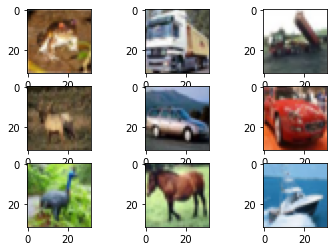

In [1]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10
# load cifar-10 dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
assert trainX.shape == (50000, 32, 32, 3)
assert testX.shape == (10000, 32, 32, 3)
assert trainy.shape == (50000, 1)
assert testy.shape == (10000, 1)
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

each image contains a single object
the images all have the same square size of 32×32 pixels
the images are color

In [2]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [3]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [4]:
# define cnn model / baseline model without data augmentation
from tensorflow.keras.regularizers import l2
def define_baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# define cnn model / Improved Data Augmented 
def define_aug_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Loss Plot')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy Plot')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=1.5, 
                    top=1.9,)
    pyplot.plot.imshow()
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [7]:
# run the test harness for evaluating a model
def run_test_baseline_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    baseline_model = define_baseline_model()
    # fit model
    steps = int(trainX.shape[0] / 64)
    baseline_csv_logger = CSVLogger('baseline_model_training.log', separator=',', append=False)
    history = baseline_model.fit(trainX, trainY, epochs=20, batch_size=64, 
                        validation_data=(testX, testY), verbose=2, callbacks=baseline_csv_logger)
    # evaluate model
    _, acc = baseline_model.evaluate(testX, testY, verbose=2)
    print('> %.3f' % (acc * 100.0))
    # save model
    baseline_model.save('final_baseline_model.h5')
    # learning curves
    summarize_diagnostics(history)

In [8]:
# run the test harness for evaluating a model
def run_test_aug_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    aug_model = define_aug_model()
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=64)
    # fit model
    steps = int(trainX.shape[0] / 64)
    aug_csv_logger = CSVLogger('aug_model_training.log', separator=',', append=False)
    history = aug_model.fit_generator(it_train, steps_per_epoch=steps, epochs=20, validation_data=(testX, testY), verbose=2, callbacks=aug_csv_logger)
    # evaluate model
    _, acc = aug_model.evaluate(testX, testY, verbose=2)
    print('> %.3f' % (acc * 100.0))
    # save model
    aug_model.save('final_aug_model.h5')
    # learning curves
    summarize_diagnostics(history)

Epoch 1/20
782/782 - 330s - loss: 2.8895 - accuracy: 0.3664 - val_loss: 2.6471 - val_accuracy: 0.4432 - 330s/epoch - 421ms/step
Epoch 2/20
782/782 - 324s - loss: 2.5410 - accuracy: 0.4855 - val_loss: 2.4650 - val_accuracy: 0.5163 - 324s/epoch - 415ms/step
Epoch 3/20
782/782 - 326s - loss: 2.3604 - accuracy: 0.5451 - val_loss: 2.2677 - val_accuracy: 0.5679 - 326s/epoch - 417ms/step
Epoch 4/20
782/782 - 323s - loss: 2.2079 - accuracy: 0.5941 - val_loss: 2.1747 - val_accuracy: 0.5995 - 323s/epoch - 413ms/step
Epoch 5/20
782/782 - 323s - loss: 2.0869 - accuracy: 0.6302 - val_loss: 2.0985 - val_accuracy: 0.6271 - 323s/epoch - 413ms/step
Epoch 6/20
782/782 - 323s - loss: 1.9870 - accuracy: 0.6577 - val_loss: 2.0538 - val_accuracy: 0.6300 - 323s/epoch - 413ms/step
Epoch 7/20
782/782 - 323s - loss: 1.8997 - accuracy: 0.6829 - val_loss: 1.9372 - val_accuracy: 0.6632 - 323s/epoch - 413ms/step
Epoch 8/20
782/782 - 322s - loss: 1.8116 - accuracy: 0.7056 - val_loss: 1.9030 - val_accuracy: 0.6655 - 

AttributeError: 'function' object has no attribute 'imshow'

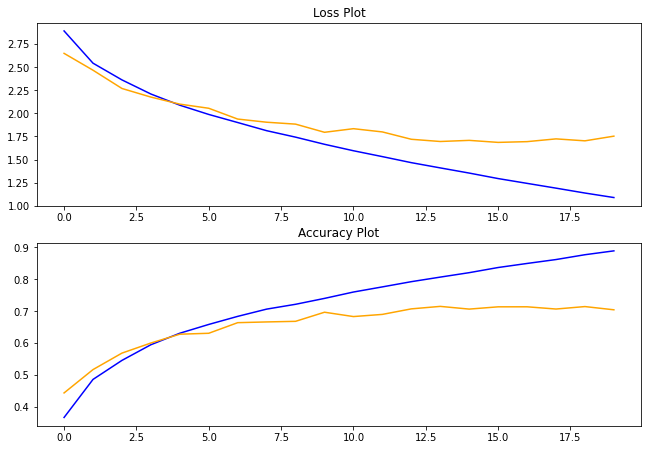

In [10]:
# entry point, run the baseline harness
run_test_baseline_harness()

C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-8-774a8d598d01>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = aug_model.fit_generator(it_train, steps_per_epoch=steps, epochs=20, validation_data=(testX, testY), verbose=2, callbacks=aug_csv_logger)


Epoch 1/20
781/781 - 348s - loss: 1.8171 - accuracy: 0.3371 - val_loss: 1.5799 - val_accuracy: 0.4278 - 348s/epoch - 446ms/step
Epoch 2/20
781/781 - 337s - loss: 1.4903 - accuracy: 0.4619 - val_loss: 1.3152 - val_accuracy: 0.5217 - 337s/epoch - 431ms/step
Epoch 3/20
781/781 - 331s - loss: 1.3453 - accuracy: 0.5170 - val_loss: 1.2321 - val_accuracy: 0.5700 - 331s/epoch - 423ms/step
Epoch 4/20
781/781 - 331s - loss: 1.2452 - accuracy: 0.5581 - val_loss: 1.0970 - val_accuracy: 0.6159 - 331s/epoch - 424ms/step
Epoch 5/20
781/781 - 330s - loss: 1.1482 - accuracy: 0.5899 - val_loss: 1.0910 - val_accuracy: 0.6247 - 330s/epoch - 423ms/step
Epoch 6/20
781/781 - 331s - loss: 1.0768 - accuracy: 0.6165 - val_loss: 0.9806 - val_accuracy: 0.6536 - 331s/epoch - 424ms/step
Epoch 7/20
781/781 - 334s - loss: 1.0105 - accuracy: 0.6448 - val_loss: 0.9261 - val_accuracy: 0.6761 - 334s/epoch - 428ms/step
Epoch 8/20
781/781 - 337s - loss: 0.9563 - accuracy: 0.6648 - val_loss: 0.9369 - val_accuracy: 0.6780 - 

AttributeError: 'function' object has no attribute 'imshow'

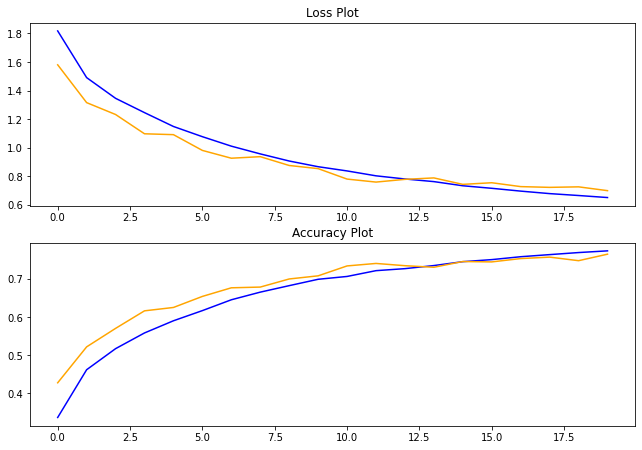

In [9]:
# entry point, run the Augmented harness
run_test_aug_harness()

Make Prediction

In [21]:
pwd

'F:\\Uni\\Bachelor Project\\data'

dog.4016.jpg
F:\Uni\Bachelor Project\data\dogs-vs-cats\resultTest\dog.4016.jpg
[[9.7659373e-05 4.2683512e-02 3.3703654e-03 8.4625310e-01 2.1901121e-02
  3.8399084e-03 1.0267830e-02 8.5946311e-05 6.5399603e-05 7.1435213e-02]]
[[0.00974485 0.01305678 0.16443966 0.32536942 0.05525719 0.16016087
  0.14062291 0.09044913 0.01072246 0.03017676]]
3
baseline:  airplane
augmented:  cat
2.0326201915740967


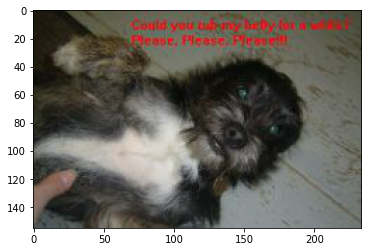

In [62]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(32, 32))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 32, 32, 3)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

# load an image and predict the class
def run_example():
    class_nmes=['dog','cat']
    chosen_image = random.choice(os.listdir('F:\\Uni\\Bachelor Project\\data\\dogs-vs-cats\\resultTest\\'))
    print(chosen_image)
    image_path = 'F:\\Uni\\Bachelor Project\\data\\dogs-vs-cats\\resultTest\\' + chosen_image
    print(image_path)
    assert os.path.isfile(image_path)
    #obtain image
    image = np.expand_dims(plt.imread(image_path),0)
    plt.imshow(image[0])
    # load the image
    img = load_image(image_path)
    # load model
    baseline_model = load_model('final_baseline_model.h5')
    baseline_log_data = pd.read_csv('baseline_model_training.log', sep=',', engine='python')
    aug_model = load_model('final_aug_model.h5')
    aug_log_data = pd.read_csv('aug_model_training.log', sep=',', engine='python')
    # predict the class
    baseline_result = baseline_model.predict(img)
    baseline_classes=np.argmax(baseline_result,axis=1)
    
    aug_result = aug_model.predict(img)
    aug_classes=np.argmax(aug_result,axis=1)
    print(baseline_result)
    print(aug_result)
    print(aug_classes[0])
    #aug_result=random.randint(0, 1)
    if aug_classes[0] >= 5:
        aug_classes[0]=1
    else:
        aug_classes[0]=0
    class_names = ['cat', 'dog', 'frog', 'airplane', 'automobile',
               'deer', 'horse', 'horse', 'ship', 'truck']
    print("baseline: ",class_names[np.argmax(baseline_result)])
    print("augmented: ",class_names[aug_classes[0]])

# entry point, run the example
import time
seconds = time.time()
run_example()
print(time.time()-seconds)